# Demo Notebook:
## DeSurv

In [2]:
import os
from pathlib import Path
import sys
node_type = os.getenv('BB_CPU')
venv_dir = f'/rds/homes/g/gaddcz/Projects/CPRD/virtual-envTorch2.0-{node_type}'
venv_site_pkgs = Path(venv_dir) / 'lib' / f'python{sys.version_info.major}.{sys.version_info.minor}' / 'site-packages'
if venv_site_pkgs.exists():
    sys.path.insert(0, str(venv_site_pkgs))
    print(f"Added path '{venv_site_pkgs}' at start of search paths.")
else:
    print(f"Path '{venv_site_pkgs}' not found. Check that it exists and/or that it exists for node-type '{node_type}'.")

%load_ext autoreload
%autoreload 2

Added path '/rds/homes/g/gaddcz/Projects/CPRD/virtual-envTorch2.0-icelake/lib/python3.10/site-packages' at start of search paths.


In [3]:
import pytorch_lightning
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sqlite3
from dataclasses import dataclass
import logging
from CPRD.data.foundational_loader import FoundationalDataModule
import pickle
from tqdm import tqdm

from pycox.datasets import support
from pycox.evaluation import EvalSurv
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from torch.utils.data import TensorDataset, DataLoader

from CPRD.src.modules.head_layers.survival.desurv import ODESurvSingle
from CPRD.src.modules.head_layers.survival.desurv import ODESurvMultiple
from CPRD.src.modules.head_layers.survival.desurv_original import ODESurvSingle as ODESurvSingleOriginal1
from CPRD.src.modules.head_layers.survival.desurv_original import ODESurvMultiple as ODESurvMultipleOriginal1
from DeSurv.src.classes import ODESurvSingle as ODESurvSingleOriginal2
from DeSurv.src.classes import ODESurvMultiple as ODESurvMultipleOriginal2

torch.manual_seed(1337)
logging.basicConfig(level=logging.INFO)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"    # if more informative debugging statements are needed
print(f"Using device: {device}.")

Using device: cuda.


# Load data

In [24]:
def get_dataloaders(dataset, competing_risk, sample_size=None):

    match dataset.lower():
        case "pycox":
            df_train = support.read_df()
            df_test = df_train.sample(frac=0.2)
            df_train = df_train.drop(df_test.index)
            df_val = df_train.sample(frac=0.2)
            df_train = df_train.drop(df_val.index)
            
            cols_standardize = ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
            cols_leave = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
            
            standardize = [([col], StandardScaler()) for col in cols_standardize]
            leave = [(col, None) for col in cols_leave]
            
            x_mapper = DataFrameMapper(standardize + leave)
            
            x_train = x_mapper.fit_transform(df_train).astype('float32')
            x_val = x_mapper.transform(df_val).astype('float32')
            x_test = x_mapper.transform(df_test).astype('float32')
            
            get_target = lambda df: (df['duration'].values, df['event'].values)
            y_train = get_target(df_train)
            y_val = get_target(df_val)
            y_test = get_target(df_test)
            
            t_train, e_train = y_train
            t_val, e_val = y_val
            t_test, e_test = y_test
            
            t_train_max = np.amax(t_train)
            t_train = t_train / t_train_max
            t_val = t_val / t_train_max
            t_test = t_test / t_train_max
            
    
        case "hypertension" | "cvd":
    
            # Training samples
            if sample_size is not None:
                save_path =  f"/rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_{dataset}/" + f"benchmark_data/N={sample_size}.pickle" 
            else:
                save_path = f"/rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_{dataset}/" + "benchmark_data/all.pickle"
                
            with open(save_path, "rb") as handle:
                print(f"Loading training dataset from {save_path}")
                data_train = pickle.load(handle)
            
            # display(data["X_train"].head())
            # display(data["y_train"])
            # print(data.keys())
            
            data = {}
            data["X_train"] = data_train["X_train"]
            data["y_train"] = data_train["y_train"]
    
            # Test and validation samples
    
            save_path = f"/rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_{dataset}/" + "benchmark_data/all.pickle"
            with open(save_path, "rb") as handle:
                print(f"Loading validation/test datasets from {save_path}")
                data_val_test = pickle.load(handle)
                
            data["X_val"] = data_val_test["X_val"]
            data["y_val"] = data_val_test["y_val"]
            data["X_test"] = data_val_test["X_test"]
            data["y_test"] = data_val_test["y_test"]
    
    
            # Convert to correct formats
            x_train = data["X_train"].to_numpy(dtype=np.float32)
            x_val = data["X_val"].to_numpy(dtype=np.float32)
            x_test = data["X_test"].to_numpy(dtype=np.float32)
            
            t_train = np.asarray([i[1] for i in data["y_train"]])
            t_val = np.asarray([i[1] for i in data["y_val"]])        
            t_test = np.asarray([i[1] for i in data["y_test"]])
    
            if competing_risk is False:
                e_train = np.asarray([0 if i[0] == 0 else 1 for i in data["y_train"]])
                e_val = np.asarray([0 if i[0] == 0 else 1 for i in data["y_val"]])
                e_test = np.asarray([0 if i[0] == 0 else 1 for i in data["y_test"]])
            else:
                e_train = np.asarray([i[0] for i in data["y_train"]])
                e_val = np.asarray([i[0] for i in data["y_val"]])
                e_test = np.asarray([i[0] for i in data["y_test"]])

    # display(x_train.shape)
    # display(type(x_train))
    # display(type(x_train[0,0]))
    # display(e_train.shape)
    # display(type(e_train))
    # display(type(e_train[0]))
    # display(t_train.shape)
    # display(type(t_train))
    # display(type(t_train[0]))
    # print(np.mean(e_train))
    # print(np.mean(t_train))
    # print(np.std(t_train))
    # print(np.mean(x_train))
    # print(t_train.min())
    print(t_train.max())
    
    batch_size = 256
    dataset_train = TensorDataset(*[torch.tensor(u,dtype=dtype_) for u, dtype_ in [(x_train,torch.float32),
                                                                                   (t_train,torch.float32),
                                                                                   (e_train,torch.long)]])
    data_loader_train = DataLoader(dataset_train, batch_size=batch_size, pin_memory=True, shuffle=True, drop_last=True)
    
    dataset_val = TensorDataset(*[torch.tensor(u,dtype=dtype_) for u, dtype_ in [(x_val,torch.float32),
                                                                                   (t_val,torch.float32),
                                                                                   (e_val,torch.long)]])
    data_loader_val = DataLoader(dataset_val, batch_size=batch_size, pin_memory=True, shuffle=True)
    
    dataset_test = TensorDataset(*[torch.tensor(u,dtype=dtype_) for u, dtype_ in [(x_test,torch.float32),
                                                                                   (t_test,torch.float32),
                                                                                   (e_test,torch.long)]])
    data_loader_test = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, shuffle=True)

    return data_loader_train, data_loader_val, data_loader_test




In [25]:
dataset = "CVD"
competing_risk = False
sample_size = 600

data_loader_train, data_loader_val, data_loader_test = get_dataloaders(dataset, competing_risk, sample_size=sample_size)




print(np.unique(e_test, return_counts=True))

data.keys()

Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=600.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.230685234069824
(array([0, 1]), array([14,  2]))


dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test'])

In [15]:
# data["X_train"].iloc[subsample_indicies].shape
# def divide_chunks(array, n):
#     for i in range(0, array.shape[0], n): 
#         yield array[i:i + n, :]

for batch in data_loader_test:
    print(batch[0].shape)
    print(batch[1])
    print(batch[2].shape)
    break

torch.Size([256, 279])
tensor([0.3951, 2.3644, 0.3085, 1.2636, 2.0071, 1.6367, 1.1090, 2.3682, 3.3331,
        3.0126, 1.4219, 0.4866, 0.5260, 1.6592, 1.4301, 0.5545, 1.6964, 1.8066,
        0.1019, 0.1436, 0.2860, 0.9326, 0.3255, 3.1386, 1.5836, 4.1951, 1.3107,
        2.3134, 3.3940, 1.8416, 0.3118, 3.2740, 2.0647, 1.4055, 1.8953, 2.0482,
        0.5397, 2.5238, 2.5742, 0.7332, 0.6066, 2.1090, 0.4444, 1.2959, 2.9907,
        0.2575, 0.2553, 0.3775, 3.2499, 2.3803, 2.4093, 0.5600, 3.0679, 2.3200,
        2.5047, 0.0115, 1.9556, 1.9660, 3.6296, 1.1529, 0.4981, 0.8126, 1.4153,
        1.8773, 1.1907, 1.2493, 0.1830, 2.4208, 0.0405, 1.5512, 2.2367, 0.8471,
        1.3578, 1.4236, 0.3879, 2.0800, 0.2115, 0.8088, 3.0427, 0.0268, 2.3425,
        0.3704, 2.3162, 3.3315, 2.7742, 0.0203, 0.7934, 0.4186, 0.5868, 0.7715,
        1.7989, 0.5584, 0.9008, 3.5710, 0.2411, 2.9984, 0.3956, 0.0619, 0.4000,
        1.7868, 2.0312, 3.2630, 2.5353, 1.3836, 1.5293, 1.6252, 2.9567, 1.9436,
        3.1759, 1

# Train model

In [93]:
# hidden_dim = 32
dataset = "CVD" # "Hypertension"
competing_risk = False
sample_sizes = [60, 150,300, 600, 1200, 3000, 6000, 12500, 30000, 60000, None]

training = True
lr = 1e-3
xdim = x_train.shape[1]

# the time grid which we generate over
t_eval = np.linspace(0, 1, 1000) 
# the time grid which we calculate scores over
time_grid = np.linspace(start=0, stop=1 , num=300)


models, model_names = [], []
if competing_risk is False:
    models.append(ODESurvSingle(xdim, [32, 32], device=device))
    model_names.append(f"{dataset}_sr_natalia_")
    # models.append(ODESurvSingleOriginal1(xdim, hidden_dim, device=device))
    # model_names.append(f"{dataset}_sr_original1_")
    # models.append(ODESurvSingleOriginal2(lr, xdim, hidden_dim, device=device))
    # model_names.append(f"{dataset}_sr_original2_")
else:
    models.append(ODESurvMultiple(xdim, [32, 32], num_risks=6))
    model_names.append(f"{dataset}_cr_natalia_")
    # models.append(ODESurvMultipleOriginal1(xdim, hidden_dim, num_risks=6))
    # model_names.append(f"{dataset}_cr_original1_")
    # models.append(ODESurvMultipleOriginal2(lr, xdim, hidden_dim, num_risks=6))
    # model_names.append(f"{dataset}_cr_original2_")

all_ctd, all_ibs, all_inbll = [], [], []
for model_name, model in zip(model_names, models):

    print(f"\n\n{model_name} with {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

    for sample_size in sample_sizes:
    
        data_loader_train, data_loader_val, data_loader_test = get_dataloaders(dataset, competing_risk, sample_size=sample_size)
    
        if training:
            print(f"Training")
            model.optimize(data_loader_train, n_epochs=20, logging_freq=1, data_loader_val=data_loader_val, max_wait=2)
            print("finished training")
            torch.save(model.state_dict(), model_name + "tst_model")
            model.eval()
    
        print(f"Testing")    
        state_dict = torch.load(model_name + "tst_model")
        model.load_state_dict(state_dict)
        model.eval()
        
        # argsortttest = np.argsort(t_test)
        # t_test = t_test[argsortttest]
        # e_test = e_test[argsortttest]
        # x_test = x_test[argsortttest,:]
        
        with torch.no_grad():
    
            ctd = []
            ibs = []
            inbll = []
            for batch in tqdm(data_loader_test, total=(len(data_loader_test)), desc="Testing"):
    
                x_test = batch[0].numpy()
                t_test = batch[1].numpy()
                e_test = batch[2].numpy()
    
                # The normalised grid over which to predict
                t_test_grid = torch.tensor(np.concatenate([t_eval] * x_test.shape[0], 0), dtype=torch.float32)
                x_test_grid = torch.tensor(x_test, dtype=torch.float32).repeat_interleave(t_eval.size, 0)
                
                pred_bsz = 51200
                pred = []
                for x_test_batched, t_test_batched in zip(torch.split(x_test_grid, pred_bsz), torch.split(t_test_grid, pred_bsz)):
                    
                    if competing_risk is False:
                        pred_ = model.predict(x_test_batched, t_test_batched)          # shape: (x_test.batched.shape[0],)
                    else:
                        pred_, pi_  = model.predict(x_test_batched, t_test_batched)    # shape: (x_test.batched.shape[0], num_outcomes)
                        # pred_ = pred_ #* pi_                  # \sum_k={1,...,K} not \emptyset F_k
                    pred.append(pred_)
                        
                pred = torch.concat(pred)
            
                pred = pred.reshape((x_test.shape[0], t_eval.size, -1)).cpu().detach().numpy()
                preds = [pred[:, :, _i] for _i in range(pred.shape[-1])]
                # print([_.shape for _ in preds])
        
                # Merge (additively) each outcome risk curve into a single CDF, and update label for if outcome occurred or not
                cdf = np.zeros_like(preds[0])
                lbls = np.zeros_like(e_test)     
                for _outcome_token in np.unique(e_test)[1:]:
                    # print(f"{_outcome_token} of {np.unique(e_test)[1:]} included from {len(preds)} surv CDFs")
                    # print(_outcome_token)
                    cdf += preds[_outcome_token - 1] 
                    lbls += (e_test == _outcome_token)
                
                surv = pd.DataFrame(np.transpose((1 - cdf.reshape((x_test.shape[0],t_eval.size)))), index=t_eval)
    
                # Evaluate surv curve with unscaled index with unscaled test times to event 
                ev = EvalSurv(surv, t_test, lbls, censor_surv='km')
                try:
                    # Same treatment as in SurvivEHR
                    ctd.append(ev.concordance_td())
                    ibs.append(ev.integrated_brier_score(time_grid))
                    inbll.append(ev.integrated_nbll(time_grid))
                except:
                    pass
                
            ctd = np.mean(ctd)
            ibs = np.mean(ibs)
            inbll = np.mean(inbll)
            

        all_ctd.append(ctd)
        all_ibs.append(ibs)
        all_inbll.append(inbll)
        



CVD_sr_natalia_ with 10081 parameters
Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=60.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.223012924194336
Training
	Epoch:  0. Total loss:        0.00
best_epoch: 0
	Epoch:  0. Total val loss:    32923.52
	Epoch:  1. Total loss:        0.00
best_epoch: 1
	Epoch:  1. Total val loss:    32923.52
	Epoch:  2. Total loss:        0.00
best_epoch: 2
	Epoch:  2. Total val loss:    32923.52
	Epoch:  3. Total loss:        0.00
best_epoch: 3
	Epoch:  3. Total val loss:    32923.52
	Epoch:  4. Total loss:        0.00
	Epoch:  4. Total val loss:    32923.52
	Epoch:  5. Total loss:        0.00
best_epoch: 5
	Epoch:  5. Total val loss:    32923.52
	Epoch:  6. Total loss:        0.00
	Epoch:  6. Total val loss:    32923.52
	Epoch:  7. Total loss:   

Testing: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=150.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.077808380126953
Training
	Epoch:  0. Total loss:        0.00
best_epoch: 0
	Epoch:  0. Total val loss:    32923.52
	Epoch:  1. Total loss:        0.00
best_epoch: 1
	Epoch:  1. Total val loss:    32923.52
	Epoch:  2. Total loss:        0.00
	Epoch:  2. Total val loss:    32923.52
	Epoch:  3. Total loss:        0.00
	Epoch:  3. Total val loss:    32923.52
	Epoch:  4. Total loss:        0.00
finished training
Testing


Testing: 100%|██████████| 40/40 [00:11<00:00,  3.37it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=300.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.39013671875
Training
	Epoch:  0. Total loss:      249.30
best_epoch: 0
	Epoch:  0. Total val loss:    32272.72
	Epoch:  1. Total loss:      249.64
best_epoch: 1
	Epoch:  1. Total val loss:    31643.80
	Epoch:  2. Total loss:      242.75
best_epoch: 2
	Epoch:  2. Total val loss:    31037.23
	Epoch:  3. Total loss:      240.33
best_epoch: 3
	Epoch:  3. Total val loss:    30439.47
	Epoch:  4. Total loss:      230.74
best_epoch: 4
	Epoch:  4. Total val loss:    29840.69
	Epoch:  5. Total loss:      225.98
best_epoch: 5
	Epoch:  5. Total val loss:    29239.32
	Epoch:  6. Total loss:      218.22
best_epoch: 6
	Epoch:  6. Total val loss:    28635.16
	Epoch:  7. Total loss:      214.39
best_

Testing: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=600.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.230685234069824
Training
	Epoch:  0. Total loss:      320.31
best_epoch: 0
	Epoch:  0. Total val loss:    19730.15
	Epoch:  1. Total loss:      299.39
best_epoch: 1
	Epoch:  1. Total val loss:    18788.68
	Epoch:  2. Total loss:      285.14
best_epoch: 2
	Epoch:  2. Total val loss:    17977.34
	Epoch:  3. Total loss:      269.80
best_epoch: 3
	Epoch:  3. Total val loss:    17317.55
	Epoch:  4. Total loss:      276.62
best_epoch: 4
	Epoch:  4. Total val loss:    16829.72
	Epoch:  5. Total loss:      262.12
best_epoch: 5
	Epoch:  5. Total val loss:    16497.21
	Epoch:  6. Total loss:      260.31
best_epoch: 6
	Epoch:  6. Total val loss:    16284.33
	Epoch:  7. Total loss:      254.63
b

Testing: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=1200.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.3249311447143555
Training
	Epoch:  0. Total loss:      453.07
best_epoch: 0
	Epoch:  0. Total val loss:    15188.29
	Epoch:  1. Total loss:      454.27
best_epoch: 1
	Epoch:  1. Total val loss:    15007.33
	Epoch:  2. Total loss:      450.28
best_epoch: 2
	Epoch:  2. Total val loss:    14837.63
	Epoch:  3. Total loss:      434.11
best_epoch: 3
	Epoch:  3. Total val loss:    14692.85
	Epoch:  4. Total loss:      428.32
best_epoch: 4
	Epoch:  4. Total val loss:    14587.09
	Epoch:  5. Total loss:      415.88
best_epoch: 5
	Epoch:  5. Total val loss:    14508.12
	Epoch:  6. Total loss:      416.86
best_epoch: 6
	Epoch:  6. Total val loss:    14431.51
	Epoch:  7. Total loss:      399.59

Testing: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=3000.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.401644706726074
Training
	Epoch:  0. Total loss:     1121.04
best_epoch: 0
	Epoch:  0. Total val loss:    14294.69
	Epoch:  1. Total loss:     1095.16
best_epoch: 1
	Epoch:  1. Total val loss:    14252.86
	Epoch:  2. Total loss:     1092.15
best_epoch: 2
	Epoch:  2. Total val loss:    14234.91
	Epoch:  3. Total loss:     1082.31
best_epoch: 3
	Epoch:  3. Total val loss:    14191.00
	Epoch:  4. Total loss:     1066.33
	Epoch:  4. Total val loss:    14209.14
	Epoch:  5. Total loss:     1041.44
	Epoch:  5. Total val loss:    14210.80
	Epoch:  6. Total loss:     1049.83
finished training
Testing


Testing: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=6000.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.402191162109375
Training
	Epoch:  0. Total loss:     2489.39
best_epoch: 0
	Epoch:  0. Total val loss:    14097.96
	Epoch:  1. Total loss:     2453.17
best_epoch: 1
	Epoch:  1. Total val loss:    14064.60
	Epoch:  2. Total loss:     2428.45
	Epoch:  2. Total val loss:    14152.48
	Epoch:  3. Total loss:     2402.55
	Epoch:  3. Total val loss:    14142.71
	Epoch:  4. Total loss:     2377.12
finished training
Testing


Testing: 100%|██████████| 40/40 [00:11<00:00,  3.37it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=12500.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.402191162109375
Training
	Epoch:  0. Total loss:     5485.86
best_epoch: 0
	Epoch:  0. Total val loss:    14002.14
	Epoch:  1. Total loss:     5354.02
best_epoch: 1
	Epoch:  1. Total val loss:    13918.36
	Epoch:  2. Total loss:     5302.18
	Epoch:  2. Total val loss:    13923.16
	Epoch:  3. Total loss:     5251.76
	Epoch:  3. Total val loss:    13971.01
	Epoch:  4. Total loss:     5198.98
finished training
Testing


Testing: 100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=30000.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.402191162109375
Training
	Epoch:  0. Total loss:    12688.29
best_epoch: 0
	Epoch:  0. Total val loss:    13778.82
	Epoch:  1. Total loss:    12493.42
best_epoch: 1
	Epoch:  1. Total val loss:    13766.97
	Epoch:  2. Total loss:    12370.87
	Epoch:  2. Total val loss:    13783.51
	Epoch:  3. Total loss:    12235.38
	Epoch:  3. Total val loss:    13819.17
	Epoch:  4. Total loss:    12094.32
finished training
Testing


Testing: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/N=60000.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.402191638946533
Training
	Epoch:  0. Total loss:    22711.50
best_epoch: 0
	Epoch:  0. Total val loss:    13674.29
	Epoch:  1. Total loss:    22525.94
	Epoch:  1. Total val loss:    13676.45
	Epoch:  2. Total loss:    22371.67
	Epoch:  2. Total val loss:    13699.41
	Epoch:  3. Total loss:    22203.47
finished training
Testing


Testing: 100%|██████████| 40/40 [00:07<00:00,  5.07it/s]


Loading training dataset from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
Loading validation/test datasets from /rds/projects/g/gokhalkm-optimal/OPTIMAL_MASTER_DATASET/data/FoundationalModel/FineTune_CVD/benchmark_data/all.pickle
4.402192115783691
Training
	Epoch:  0. Total loss:   241017.40
best_epoch: 0
	Epoch:  0. Total val loss:    13477.95
	Epoch:  1. Total loss:   239502.65
best_epoch: 1
	Epoch:  1. Total val loss:    13477.14
	Epoch:  2. Total loss:   238804.12
best_epoch: 2
	Epoch:  2. Total val loss:    13444.64
	Epoch:  3. Total loss:   238448.67
best_epoch: 3
	Epoch:  3. Total val loss:    13436.44
	Epoch:  4. Total loss:   238006.06
best_epoch: 4
	Epoch:  4. Total val loss:    13419.61
	Epoch:  5. Total loss:   237757.75
	Epoch:  5. Total val loss:    13443.29
	Epoch:  6. Total loss:   237441.18
best_epoch: 6
	Epoch:  6. Total val loss:    13416.56
	Epoch:  7. Total loss:   237090.89
	Epoch:  7. Total

Testing: 100%|██████████| 40/40 [00:04<00:00,  9.91it/s]


In [77]:
sample_sizes[-1] = 572096
print(sample_sizes)
print(all_ctd)
print(all_ibs)
print(all_inbll)

[60, 150, 300, 600, 1200, 3000, 6000, 12500, 30000, 60000, 572096]
[0.4775449749370175, 0.4827333973620376, 0.5357172953526594, 0.5336275536106092, 0.5988851086146271, 0.6531392305916313, 0.6928729008141945, 0.6884741763166558, 0.7043233570843503, 0.7130953415664079, 0.7440877424711232]
[0.13191622488517826, 0.1315898548467807, 0.10217796417061793, 0.09751837181071318, 0.09440067233567603, 0.09336752555613431, 0.09088050681805858, 0.09147577528987297, 0.09195689976524132, 0.08929771777960704, 0.08622211662922612]
[0.4260044727006793, 0.4251954229724729, 0.3525563155964234, 0.3516942199810025, 0.33538976683980637, 0.32415381149953976, 0.3063005576890835, 0.30511349153394235, 0.30071103144799793, 0.29192514047540175, 0.2790575106128915]


In [91]:
# SurvivEHR-CR (FT-SR) results
if dataset == "CVD":
    survivEHRsr_sample_sizes = [60, 3000, 12500, 572096]
    survivEHRsr_all_ctd = [0.408, 0.616, 0.626, 0.650]
    survivEHRsr_all_ibs = [0.0345, 0.0338,0.0338, 0.0336]
    survivEHRsr_all_inbll = [0.155, 0.145, 0.145, 0.143]

    survivEHRcr_sample_sizes = [60]
    survivEHRcr_all_ctd = [0.407]
    survivEHRcr_all_ibs = [0.0350]
    survivEHRcr_all_inbll = [0.157]

elif dataset == "Hypertension":
    survivEHRsr_sample_sizes = [572096]
    survivEHRsr_all_ctd = [0.741]
    survivEHRsr_all_ibs = [0.0854]
    survivEHRsr_all_inbll = [0.285]

    survivEHRcr_sample_sizes = []
    survivEHRcr_all_ctd = []
    survivEHRcr_all_ibs = []
    survivEHRcr_all_inbll = []


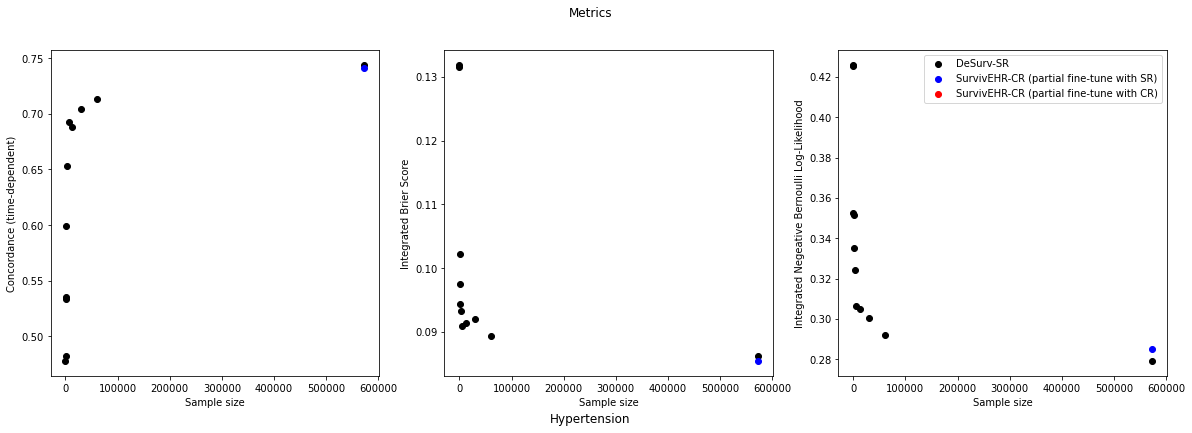

In [92]:
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(20,6))
fig.suptitle('Metrics')


axs[0].scatter(sample_sizes, all_ctd, c='k')
axs[0].scatter(survivEHRsr_sample_sizes, survivEHRsr_all_ctd, c='b')
axs[0].scatter(survivEHRcr_sample_sizes, survivEHRcr_all_ctd, c='r')
axs[0].set_ylabel("Concordance (time-dependent)")

axs[1].scatter(sample_sizes, all_ibs, c='k')
axs[1].scatter(survivEHRsr_sample_sizes, survivEHRsr_all_ibs, c='b')
axs[1].scatter(survivEHRcr_sample_sizes, survivEHRcr_all_ibs, c='r')

axs[1].set_ylabel("Integrated Brier Score")

axs[2].scatter(sample_sizes, all_inbll, c='k', label="DeSurv-SR")
axs[2].scatter(survivEHRsr_sample_sizes, survivEHRsr_all_inbll, c='b', label="SurvivEHR-CR (partial fine-tune with SR)")
axs[2].scatter(survivEHRcr_sample_sizes, survivEHRcr_all_inbll, c='r', label="SurvivEHR-CR (partial fine-tune with CR)")

axs[2].set_ylabel("Integrated Negeative Bernoulli Log-Likelihood")

for ax in axs:
    log_scale = False
    if log_scale:
        ax.set_xscale('log')
        ax.set_xlabel("Log sample size")
    else:
        ax.set_xlabel("Sample size")
        
        
fig.supxlabel(str(dataset))

plt.legend(loc=1)
    
plt.show()

In [ ]:
# 35758000 / (1000 * 1)
# print(pred.reshape(x_test.shape[0], 1000,-1).shape)
# print(x_test.shape)
# pred = np.concatenate(preds, 0)             # n_test * t_eval.size(), num_risks
# pred = pred.reshape(x_test.shape[0], 1000,-1)
# print(pred.shape)
# print([_p.shape for _p in preds])

In [ ]:
display(t_eval.max())

display(t_test.max()*5*365)

print(ev.concordance_td())
print(ev.integrated_brier_score(t_eval))
print(ev.integrated_nbll(t_eval))

